In [1]:
IRT_DIMS = 1
TEST = True

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

MAXES = 10
MINEPOCHS = 5

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 1024
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0.01
    parameters['lambda2'] = 0.02
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 

In [5]:
if TEST: 
    #DATA_FILE = 'data/mindsteps_set_matrix_20000'    
    DATA_FILE = 'data/mindsteps_set_test_matrix'    
else:
    DATA_FILE = 'data/mindsteps_set_full' 

In [6]:
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True)

(327841, 24)


In [7]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [8]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [9]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 50.97it/s]



Epoch: 001, Loss: 40283.6953, Val: 0.5045, Test: 0.5124



 10%|█         | 1/10 [00:00<00:08,  1.06it/s]

100%|██████████| 4/4 [00:00<00:00, 57.16it/s]



Epoch: 002, Loss: 39663.9727, Val: 0.5056, Test: 0.5132



 20%|██        | 2/10 [00:01<00:07,  1.05it/s]

100%|██████████| 4/4 [00:00<00:00, 43.70it/s]



Epoch: 003, Loss: 39044.6172, Val: 0.5078, Test: 0.5145



 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

100%|██████████| 4/4 [00:00<00:00, 68.86it/s]



Epoch: 004, Loss: 38435.1875, Val: 0.5099, Test: 0.5154



 40%|████      | 4/10 [00:03<00:04,  1.28it/s]

100%|██████████| 4/4 [00:00<00:00, 53.50it/s]



Epoch: 005, Loss: 37838.7422, Val: 0.5123, Test: 0.5171



 50%|█████     | 5/10 [00:04<00:03,  1.26it/s]

100%|██████████| 4/4 [00:00<00:00, 64.02it/s]



Epoch: 006, Loss: 37256.5703, Val: 0.5143, Test: 0.5189



 60%|██████    | 6/10 [00:04<00:03,  1.24it/s]

100%|██████████| 4/4 [00:00<00:00, 64.58it/s]



Epoch: 007, Loss: 36689.1953, Val: 0.5159, Test: 0.5199



 70%|███████   | 7/10 [00:05<00:02,  1.30it/s]

100%|██████████| 4/4 [00:00<00:00, 52.79it/s]



Epoch: 008, Loss: 36136.7617, Val: 0.5179, Test: 0.5223



 80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

100%|██████████| 4/4 [00:00<00:00, 68.32it/s]



Epoch: 009, Loss: 35599.1758, Val: 0.5191, Test: 0.5244



 90%|█████████ | 9/10 [00:07<00:00,  1.21it/s]

100%|██████████| 4/4 [00:00<00:00, 65.72it/s]



Epoch: 010, Loss: 35076.1797, Val: 0.5211, Test: 0.5257



100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
1it [00:08,  8.41s/it]


In [10]:
output_dict.keys()
output_dict['AUC_0_test']

0.5290498161568914

In [11]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [12]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data, train_data, val_data, test_data,
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}.pth.tar')

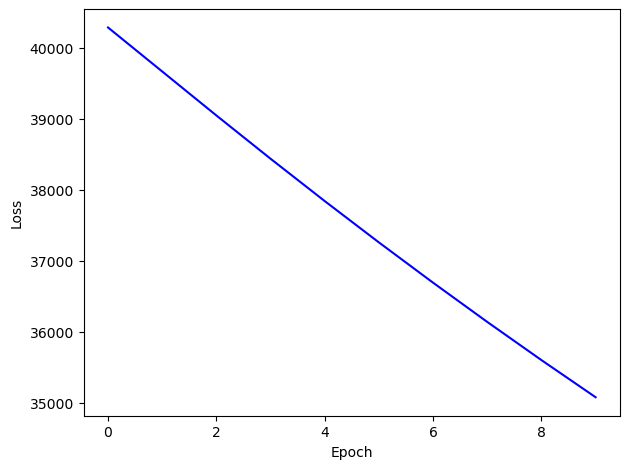

In [15]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

/tmp/ipykernel_2908797/1467811068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edge['IRT1_ability'] = ability.ravel()


PearsonRResult(statistic=-0.009146252949416258, pvalue=0.4815012479204449)
PearsonRResult(statistic=0.372205221846118, pvalue=0.0)
PearsonRResult(statistic=0.09369720705060422, pvalue=0.0)


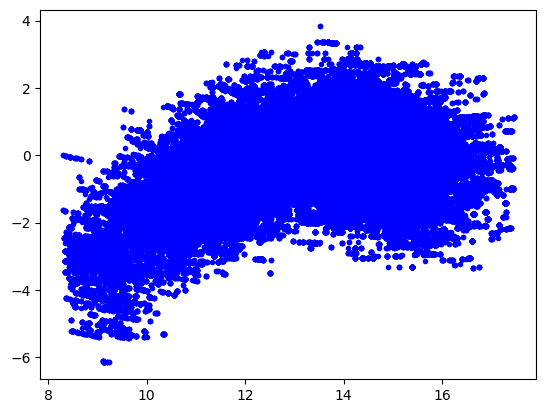

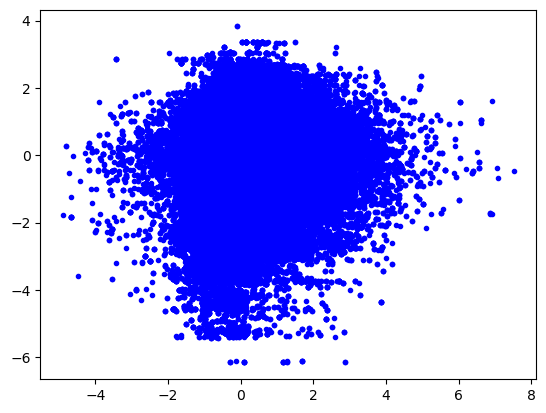

In [16]:
# save IRT parameters to matrix

if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['item']
    df_item['IRT1_discrimination'] = z_dict['offset']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data, train_data, val_data, test_data,
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    #fig = plt.figure()
    #plt.plot(df_item['IRT_difficulty'], df_item['IRT1_difficulty'], 'b.')
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])
    
    print(pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    plt.plot(df_edge_clean['age'], df_edge_clean['IRT1_ability'], 'b.')
    print(pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    plt.plot(df_edge_clean['ability'], df_edge_clean['IRT1_ability'], 'b.')
    print(pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    